# RANDOM FOREST

- Werte müssen alle numerisch sein
- nur notwendinge Features im Datensatz behalten
- Zielvariable extrahieren
- Aufteilen in Trainings- und Testdaten
- Model überprüfen 

In [1]:
import pandas as pd
import geopandas as gpd

# GeoJSON-Datei laden
gdf = gpd.read_file('../../../data/processed_data/simra_osm_all.geojson')

# Entfernen der Polygone (Geometrie) und nicht benötigter Spalten (type ist ein Feature von SimRa und kann deshlab nicht genutzt werden)
df = gdf.drop(columns=['markers', 'id', 'index_right', 'geometry', 'highway', 'incidents', 'rides', 'type'])


# Anzeigen der ersten Zeilen und Spaltennamen, um zu prüfen, wie die Daten aussehen
df.head()

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,service,tertiary,track
0,0.0,50,0.000000,1.0,0.0,0.0,0.000000,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.750000,0.0,0.000000,0.0
1,0.0,30,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0
2,0.0,50,0.846154,0.0,0.0,0.0,0.153846,0.384615,0.0,0.0,0.0,0.0,0.0,0.153846,0.461538,0.0,0.000000,0.0
3,0.0,30,0.500000,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0
4,0.0,50,1.000000,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.666667,0.0


In [2]:
df.columns

Index(['score', 'maxspeed', 'asphalt', 'concrete', 'paving_stone', 'sett',
       'unpaved', 'cycleway', 'footway', 'highway_rare', 'living_street',
       'path', 'primary', 'residential', 'secondary', 'service', 'tertiary',
       'track'],
      dtype='object')

**"score" als Zielvariable definieren**

In [3]:
# Zielvariable (Score) definieren
y = df['score']


In [4]:
# Alle anderen Spalten als Features verwenden ('score')
X = df.drop(columns=['score'])

**Datensatz splitten**

In [5]:
from sklearn.model_selection import train_test_split

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Anzahl der Trainingsdaten: {X_train.shape[0]}")
print(f"Anzahl der Testdaten: {X_test.shape[0]}")


Anzahl der Trainingsdaten: 12529
Anzahl der Testdaten: 3133


**Random Forest Modell trainieren**

In [6]:
from sklearn.ensemble import RandomForestRegressor  # Verwende RandomForestRegressor für Regression

# Random Forest Regressor Modell erstellen
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Modell trainieren
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# Vorhersagen auf den Testdaten
y_pred = rf.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mittlere quadratische Fehler (MSE): {mse:.4f}")
print(f"Bestimmtheitsmaß (R^2): {r2:.4f}")

Mittlere quadratische Fehler (MSE): 0.0025
Bestimmtheitsmaß (R^2): -0.1238


### --> äußerst ungewöhnliche Werte --> irgendwas läuft nicht richtig

**MSE = 0.0025** bedeutet, dass der durchschnittliche quadratische Unterschied zwischen den vorhergesagten Werten und den tatsächlichen Werten sehr klein ist. Das ist oft ein gutes Zeichen, da ein niedriger MSE normalerweise auf ein gut funktionierendes Modell hinweist.  
  
Allerdings sollte der MSE immer im Kontext der Skalierung der Daten betrachtet werden. Da die Zielwerte (die tatsächlichen Ergebnisse) sehr kleine Werte haben, ist dieser MSE nicht so beeindruckend, wie er auf den ersten Blick erscheint.

**R² = -0.1238** zeigt, dass das Modell schlechter als ein einfaches Durchschnittsmodell ist. Ein negatives R² bedeutet, dass das Modell in seiner Vorhersage schlechter abschneidet als die naive Vorhersage, bei der der Mittelwert der Zielvariablen als Vorhersage verwendet wird. Ein negatives R² tritt auf, wenn das Modell die Varianz der Daten nicht gut erklärt.  

Ein ideales Modell hätte ein R² nahe 1. Ein Wert von 0 bedeutet, dass das Modell keinen Zusammenhang zwischen den Eingabewerten und der Zielvariable erklären kann, und ein negativer Wert deutet darauf hin, dass das Modell in die falsche Richtung geht oder sich nicht gut an die Daten anpasst.

### mögliche Ursachen:
- Probleme beim Aufteilen der Daten
       --> bei uns nicht gegeben, weil die Aufteilung mit Anzahl der Trainingsdaten: 12529 und Anzahl der Testdaten: 3133 der typischen 80/20 Vertteilung entspricht

- Überlappung bei Trainings- und Testdaten

In [8]:
print("Kollidieren in X_train und X_test:")
print(set(X_train.index).intersection(set(X_test.index)))

print("Kollidieren in y_train und y_test:")
print(set(y_train.index).intersection(set(y_test.index)))

Kollidieren in X_train und X_test:
set()
Kollidieren in y_train und y_test:
set()


--> es gibt keine Überlappung bei Trainings- und Testdaten

- fehlende Werte, fehlerhafte Daten

In [9]:
# Überprüfe fehlende Werte in den Trainings- und Testdaten
print(X_train.isnull().sum())
print(X_test.isnull().sum())

maxspeed         0
asphalt          0
concrete         0
paving_stone     0
sett             0
unpaved          0
cycleway         0
footway          0
highway_rare     0
living_street    0
path             0
primary          0
residential      0
secondary        0
service          0
tertiary         0
track            0
dtype: int64
maxspeed         0
asphalt          0
concrete         0
paving_stone     0
sett             0
unpaved          0
cycleway         0
footway          0
highway_rare     0
living_street    0
path             0
primary          0
residential      0
secondary        0
service          0
tertiary         0
track            0
dtype: int64


--> es gibt keine fehlenden Daten oder Nullwerte im Datensatz


- Verteilung der Zielvariablen y in Trainings - und Testdaten

In [10]:
print(y_train.describe())
print(y_test.describe())

count    12529.000000
mean         0.010467
std          0.042034
min          0.000000
25%          0.000000
50%          0.000000
75%          0.005682
max          1.230854
Name: score, dtype: float64
count    3133.000000
mean        0.010410
std         0.047140
min         0.000000
25%         0.000000
50%         0.000000
75%         0.005495
max         1.522222
Name: score, dtype: float64


--> Werte sind bei beiden sehr ähnlich - das ist gut  
--> Der Mittelwert der Zielvariable ist sehr niedrig und die Standardabweichung zeigt, dass die Werte im Vergleich zu ihrem Mittelwert wenig variieren.   
--> Das bedeutet, dass die Zielvariable in den meisten Fällen nahe bei 0 liegt und nur wenige hohe Werte aufweist.

- Ein MSE von 0.0025 kann darauf hindeuten, dass das Modell möglicherweise nur sehr kleine Fehler gemacht hat, was besonders dann zutrifft, wenn die Zielwerte klein sind und sich nahe bei 0 befinden.
- Ein R² von -0.12 deutet darauf hin, dass das Modell schlechter abschneidet als ein einfaches Mittelwertmodell. Dies könnte daran liegen, dass die Zielvariable sehr wenig Varianz hat, sodass selbst kleine Fehler zu einem scheinbar perfekten Modell führen können, das aber tatsächlich keine nützliche Vorhersage liefert.

-> **Zielvariable normalisieren oder skalieren**:  
Es könnte hilfreich sein, die Zielvariable zu skalieren, wenn ihre Werte in einem sehr kleinen Bereich liegen. Dies kann durch eine Standardisierung oder Normalisierung erreicht werden. Manchmal hilft dies dabei, die Modellbewertung zu verbessern.  
--> bei Random Forest führt das im Regelfalle nicht zu besseren Ergebnissen, aber für den Modellvergleich, wenn ich anderen Modellen die Saklierung verwednet worden ist, kann es hilfreich sein

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Konvertiere die Pandas Series in NumPy Arrays und skaliere
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))


In [12]:
y_train_pred = rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Trainings-MSE: {mse_train:.4f}")
print(f"Trainings-R^2: {r2_train:.4f}")

Trainings-MSE: 0.0010
Trainings-R^2: 0.4551


###### **Interpretation der Ergebnisse**

Trainings-MSE von 0.0010:
- Der mittlere quadratische Fehler (MSE) von 0.0010 auf den Trainingsdaten deutet darauf hin, dass das Modell sehr gut an die Trainingsdaten angepasst ist, was in der Regel darauf hinweist, dass das Modell möglicherweise überfitten könnte. Das bedeutet, dass das Modell sehr gut auf den Trainingsdaten funktioniert, aber möglicherweise nicht gut auf unbekannte Testdaten generalisiert.

Trainings-R² von 0.46:
- Ein R² von 0.46 auf den Trainingsdaten bedeutet, dass das Modell etwa 46% der Varianz in den Trainingsdaten erklärt. Das ist eine moderate Leistung und deutet darauf hin, dass das Modell eine gewisse erklärende Kraft hat, aber es ist nicht perfekt.

**Überprüfe die Modellbewertung auf Testdaten**

Da das Modell auf den Trainingsdaten perfekt funktioniert, aber das R² auf den Testdaten negativ ist, gibt es einen Hinweis auf Overfitting. Überprüfe die Modellbewertung auf den Testdaten erneut:

In [13]:
# Berechne Vorhersagen auf den Testdaten
y_test_pred = rf.predict(X_test)

# Berechne MSE und R² für Testdaten
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test-MSE: {mse_test:.4f}")
print(f"Test-R^2: {r2_test:.4f}")

Test-MSE: 0.0025
Test-R^2: -0.1238


#### Mögliche Ursachen für das schlechte Abschneiden auf den Testdaten:

**Overfitting:**
        Das Modell hat sich möglicherweise zu stark an die Trainingsdaten angepasst und ist nicht in der Lage, die Testdaten gut zu verallgemeinern. Dies passiert oft, wenn das Modell zu komplex ist und sich zu sehr auf spezifische Muster in den Trainingsdaten verlässt.
        In unserem Fall könnte das Random Forest Modell zu tief gewachsene Bäume oder zu viele Bäume haben, was das Modell sehr flexibel macht, aber es nicht robust gegenüber neuen Daten.

**Zu geringe Varianz der Zielvariable:**
        Da die Zielvariable wenig Varianz aufweist und nahe bei null ist, kann das Modell Schwierigkeiten haben, sinnvolle Vorhersagen zu machen. In solchen Fällen kann das Modell lernen, einfach den Durchschnitt der Zielvariable zu prognostizieren, was zu einem negativen R² auf den Testdaten führen kann.

#### Verbesserung des Models

Es ist sinnvoll, zunächst Cross-Validation durchzuführen, bevor ein Hyperparameter-Tuning durchgeführt wird. Der Grund dafür liegt in der Methodik und im Ziel dieser beiden Schritte:

**Cross-Validation zuerst:**

Zweck der Cross-Validation: Cross-Validation hilft dabei, die Stabilität und Generalisierungsfähigkeit des Modells zu überprüfen. Mit einer k-fachen Kreuzvalidierung (z.B. 5-fold CV) kann man sicherstellen, dass das Modell auf verschiedenen Untergruppen der Daten gut funktioniert, und nicht nur auf einer bestimmten Trainings-/Testaufteilung. Cross-Validation gibt einen robusten Durchschnittswert für Metriken wie den R² oder MSE und reduziert das Risiko, dass man ein Modell trainiert, das nur zufällig auf einer bestimmten Datenaufteilung gut abschneidet.

Warum zuerst?: Bevor man versucht, das Modell durch Hyperparameter-Tuning zu optimieren, möchte man sicherstellen, dass die aktuelle Version des Modells überhaupt eine vernünftige Leistung bringt und konsistent auf den Daten trainiert wird. Wenn das Modell ohne Tuning schon stark überfittet oder schlechte Ergebnisse liefert, dann wäre es ineffizient, direkt ins Tuning zu gehen.


  **Cross-Validation**

Cross-Validation hilft dabei, die Generalisierungsfähigkeit des Modells zu überprüfen und Überanpassung zu vermeiden.   
K-Fold Cross-Validation:

In [14]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Cross-Validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print(f"Cross-Validation MSE: {cv_mse:.4f}")

# Vorhersagen durch Cross-Validation
cv_predictions = cross_val_predict(rf, X, y, cv=5)
cv_mse = mean_squared_error(y, cv_predictions)
cv_r2 = r2_score(y, cv_predictions)

print(f"Cross-Validation MSE: {cv_mse:.4f}")
print(f"Cross-Validation R^2: {cv_r2:.4f}")

Cross-Validation MSE: 0.0021
Cross-Validation MSE: 0.0021
Cross-Validation R^2: -0.1570


###### **Interpretation der Ergebnisse Cross Validation**

- Cross-Validation MSE von 0.0021:

Der mittlere quadratische Fehler (MSE) ist relativ klein, was auf den ersten Blick gut aussieht. Da die Zielvariable skaliert wurde (mit MinMaxScaler), sind die Werte kleiner und daher wirkt auch der Fehler klein.
Allerdings gibt der MSE nur die quadratische Abweichung an, ohne zu berücksichtigen, ob das Modell wirklich nützliche Vorhersagen trifft oder nicht. Ein kleiner MSE allein garantiert nicht, dass das Modell gut generalisiert.

- Cross-Validation R² von -0.1570:

Ein R²-Wert von -0.1570 zeigt, dass das Modell schlechter abschneidet als eine einfache Vorhersage des Mittelwerts der Zielvariablen. 
Ein positives R² bedeutet, dass das Modell zumindest einen Teil der Varianz der Zielvariable erklären kann, aber ein negativer Wert zeigt, dass das Modell nicht gut funktioniert.
R²-Wert von -0.1570 bedeutet, dass das Modell nicht nur ungenau ist, sondern auch die Struktur der Daten schlecht einfängt.
Der R²-Wert von ca. -0.16 bedeutet, dass das Modell 16% weniger Varianz erklärt als das einfachste Modell, das nur den Mittelwert der Zielvariablen vorhersagt.

**Hyperparameter Tuning**

Es lohnt sich, Hyperparameter-Tuning auszuprobieren, auch wenn die Ergebnisse der Cross-Validation zunächst nicht zufriedenstellend sind. Hyperparameter-Tuning kann ein Modell optimieren, indem es die besten Einstellungen für die spezifischen Daten und das Problem findet. Manchmal können schon kleine Anpassungen an den Hyperparametern die Performance eines Modells erheblich verbessern.

In [15]:
# Überprüfe die Hyperparameter des Modells
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimierter Test-MSE: {mse_best:.4f}")
print(f"Optimiertes Test-R^2: {r2_best:.4f}")

Optimierter Test-MSE: 0.0023
Optimiertes Test-R^2: -0.0309


**Interpretation der Ergebnisse**

1. Optimierter Test-MSE: 0.0023

    Der mittlere quadratische Fehler (MSE) ist etwas gestiegen im Vergleich zu dem ursprünglichen MSE von 0.0021. Das ist ein Hinweis darauf, dass das Modell möglicherweise nicht wirklich besser ist, obwohl die Hyperparameter optimiert wurden.

2. Optimiertes Test-R²: -0.0309

    Ein negativer R²-Wert zeigt, dass das Modell nicht in der Lage ist, die Varianz der Zielvariablen besser zu erklären als einfach den Mittelwert der Zielvariable zu verwenden. Das bedeutet, dass das Modell weiterhin nicht gut funktioniert.

Was bedeutet das?

Keine signifikante Verbesserung: Die Optimierung hat möglicherweise nicht zu einer signifikanten Verbesserung der Leistung geführt. Möglicherweise gibt es grundlegende Probleme mit den Daten oder den gewählten Features.
Unterfitting: Es könnte sein, dass das Modell immer noch zu einfach ist, um die zugrunde liegenden Muster in den Daten zu erfassen.



**Hyperparameter Tuning mit größerem Parameter Bereich**

**Bootstrap:**  ist eine statistische Technik, die verwendet wird, um Schätzungen der Unsicherheit und Stabilität von Modellen oder statistischen Parametern zu berechnen. Sie ist besonders nützlich, um die Genauigkeit von Schätzungen zu verbessern, indem sie zusätzliche Samples aus den bestehenden Daten zieht.  
<details>
<summary>Was ist Bootstrap?</summary>

- Definition:
        Bootstrap ist eine Resampling-Technik, bei der wiederholt Zufallsstichproben (mit Zurücklegen) aus einem vorhandenen Datensatz gezogen werden, um die Unsicherheit oder Stabilität von Schätzungen wie Mittelwerten, Medianen oder Modellparametern zu beurteilen.

- Wie es funktioniert:
        Stichproben mit Zurücklegen: Du ziehst zufällig eine Anzahl von Beobachtungen aus deinem Datensatz, wobei jede Beobachtung mehrmals ausgewählt werden kann (das nennt man "mit Zurücklegen"). Dadurch erhältst du mehrere "Bootstrap-Proben" des ursprünglichen Datensatzes.
        Modelltraining: Du trainierst das Modell auf diesen Bootstrap-Proben und bewertest es dann auf den nicht ausgewählten Daten (den "Out-of-Bag"-Daten).
        Aggregation: Die Ergebnisse dieser Bootstrap-Proben werden aggregiert, um Schätzungen der Unsicherheit oder Verteilung der Modellparameter zu erstellen.

- Bootstrap im Kontext von Random Forest

Im Random Forest-Algorithmus wird Bootstrap verwendet, um die Robustheit und Genauigkeit des Modells zu verbessern:

Bootstrap im Random Forest:
        Stichprobenziehung: Beim Training jedes Entscheidungsbaums in einem Random Forest wird eine Bootstrap-Stichprobe aus den Trainingsdaten gezogen. Dies bedeutet, dass jeder Baum auf einem zufälligen Unterdatensatz trainiert wird, der durch wiederholtes Ziehen von Beobachtungen aus den Originaldaten erstellt wurde.
        Out-of-Bag-Fehler: Die Daten, die nicht in der Bootstrap-Stichprobe enthalten sind, werden verwendet, um den Fehler des Modells zu bewerten. Diese Technik wird als Out-of-Bag (OOB) Fehlerabschätzung bezeichnet und bietet eine zusätzliche Methode zur Modellbewertung ohne separate Testdaten.

- Vorteile:
        Stabilität und Genauigkeit: Bootstrap-Proben ermöglichen es dem Random Forest, robuste Schätzungen zu liefern, indem es mehrere Modelle auf verschiedenen Stichproben trainiert und die Ergebnisse aggregiert.
        Fehlerabschätzung: Die Out-of-Bag-Bewertung bietet eine eingebaute Methode zur Fehlerabschätzung, ohne separate Testdaten zu benötigen.
</details>

Der Parameter **max_features** im Kontext eines Random Forest-Modells bestimmt, wie viele Features (Merkmale) bei der Suche nach dem besten Split für jeden Entscheidungsbaum im Wald berücksichtigt werden. Dies ist eine wichtige Hyperparameter-Einstellung, die die Leistung und das Verhalten des Modells beeinflussen kann. Hier ist eine detaillierte Erklärung der möglichen Werte für max_features:  
<details>
<summary>Mögliche Werte für max_features</summary>

- 'auto' (In neueren Versionen durch 'sqrt' ersetzt)
        Beschreibung: Früher wurde 'auto' verwendet, was für max_features dasselbe wie 'sqrt' bedeutet. In den neuesten Versionen von scikit-learn wurde dies durch 'sqrt' ersetzt.
        Bedeutung: Bei einem Random Forest wird für jeden Split in einem Entscheidungsbaum eine Zufallsauswahl von sqrt(n_features) Features berücksichtigt, wobei n_features die Gesamtanzahl der Features im Datensatz ist.

- 'sqrt'
        Beschreibung: Dies steht für die Quadratwurzel der Gesamtanzahl der Features.
        Bedeutung: Bei jedem Split in jedem Entscheidungsbaum werden sqrt(n_features) Features zufällig ausgewählt. Diese Methode reduziert die Korrelation zwischen den Bäumen und kann die Generalisierung des Modells verbessern.

- 'log2'
        Beschreibung: Dies steht für den Logarithmus zur Basis 2 der Gesamtanzahl der Features.
        Bedeutung: Bei jedem Split in jedem Entscheidungsbaum werden log2(n_features) Features zufällig ausgewählt. Dies kann nützlich sein, um die Anzahl der in Betracht gezogenen Features weiter zu reduzieren, wodurch möglicherweise auch die Modellkomplexität und die Berechnungszeit reduziert werden.

- Integer
        Beschreibung: Eine konkrete Zahl, die die Anzahl der Features angibt, die bei jedem Split in einem Baum berücksichtigt werden sollen.
        Bedeutung: Wenn du beispielsweise max_features=10 festlegst, werden bei jedem Split genau 10 Features aus der Gesamtanzahl ausgewählt.

- Float
        Beschreibung: Ein Bruchteil der Gesamtanzahl der Features, der bei jedem Split berücksichtigt wird.
        Bedeutung: Wenn du max_features=0.5 festlegst, werden 50 % der Gesamtanzahl der Features bei jedem Split in einem Baum verwendet.

- None
        Beschreibung: Keine Einschränkung auf die Anzahl der Features.
        Bedeutung: Alle Features werden bei jedem Split berücksichtigt.

Beispiel für die Verwendung von max_features

Angenommen, du hast einen Datensatz mit 20 Features:

    Wenn du max_features='sqrt' verwendest, wird bei jedem Split zufällig etwa sqrt(20) ≈ 4 Features in Betracht gezogen.
    Wenn du max_features='log2' verwendest, wird bei jedem Split zufällig etwa log2(20) ≈ 4 Features in Betracht gezogen.
    Wenn du max_features=10 verwendest, werden bei jedem Split genau 10 Features in Betracht gezogen.
    Wenn du max_features=0.5 verwendest, werden bei jedem Split 50% der Features (also etwa 10) in Betracht gezogen.

Einfluss auf das Modell

    Weniger Features (max_features kleiner): Reduziert die Korrelation zwischen den Bäumen im Random Forest, was oft zu einer besseren Generalisierung führt. Kann jedoch auch die Leistung verschlechtern, wenn zu wenige Features berücksichtigt werden.
    Mehr Features (max_features größer): Erhöht die Korrelation zwischen den Bäumen, was zu einer besseren Leistung auf den Trainingsdaten führen kann, aber möglicherweise zu Überanpassung (Overfitting) auf den Testdaten.

Zusammenfassung

    'sqrt' und 'log2' sind standardmäßige und häufig empfohlene Einstellungen für max_features, da sie eine gute Balance zwischen Modellkomplexität und Overfitting bieten.
    Integer und Float-Werte bieten Flexibilität, um spezifische Anzahlen oder Prozentsätze von Features zu berücksichtigen.
    None verwendet alle verfügbaren Features, was zu einem möglicherweise überangepassten Modell führen kann.

Du kannst max_features durch Experimentieren mit verschiedenen Werten und durch die Überprüfung der Modellleistung optimieren.
</details>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definiere die Hyperparameter-Suchraum
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialisiere das Modell
rf = RandomForestRegressor(random_state=42)

# Führe RandomizedSearchCV durch
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Hole den besten Schätzer und zeige die besten Parameter und den besten Score an
best_rf = random_search.best_estimator_
print("Beste Parameter gefunden:")
print(random_search.best_params_)
print("Bester Score (neg_mean_squared_error):")
print(random_search.best_score_)



**1. Beste Parameter**

bootstrap: True: Dies zeigt, dass das Modell Daten mit Wiederholung zieht, was typischerweise zu robusteren Modellen führt.

max_depth: 10: Eine moderate Baumtiefe, die helfen kann, Überanpassung zu vermeiden.

max_features: 'sqrt': Das bedeutet, dass bei jedem Split nur die Quadratwurzel der Features betrachtet wird, was zur Diversität der Bäume beiträgt.

min_samples_leaf: 7 und min_samples_split: 12: Diese Werte sind relativ hoch, was darauf hindeutet, dass das Modell stabiler ist und weniger anfällig für Überanpassung.

n_estimators: 252: Eine ausreichende Anzahl von Bäumen, um die Vorhersagen zu stabilisieren.


**2. Bester Score**

Bester Score (neg_mean_squared_error): -0.0017531746543460584
    Beschreibung: Der beste neg_mean_squared_error-Wert (negativer mittlerer quadratischer Fehler) ist ein Maß für die Modellleistung auf den Trainingsdaten. Da RandomizedSearchCV den negativen MSE maximiert (d.h. den MSE minimiert), ist ein kleinerer negativer Wert besser.
        Interpretation: Ein Wert von -0.00175 ist relativ klein und deutet darauf hin, dass das Modell auf den Trainingsdaten gut abschneidet. Allerdings ist es wichtig, diesen Wert auch im Kontext des tatsächlichen MSEs und der Leistung auf den Testdaten zu betrachten.

**--> Leistung des besten Modells auf den Testdaten überprüfen, da dies eine bessere Einschätzung der Modellgeneralisation bietet. Berechnung des MSE und den R²-Score auf den Testdaten, um zu sehen, ob das Modell gut generalisiert.**

In [ ]:
y_test_pred = best_rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test-MSE: {mse_test:.4f}")
print(f"Test-R^2: {r2_test:.4f}")


**Interpretation der Ergebnisse**

- 1. Test-MSE: 0.0022

    Der MSE ist leicht gestiegen im Vergleich zu den vorherigen Ergebnissen. Ein kleiner MSE ist gut, aber es ist wichtig, ihn im Kontext der Variabilität der Zielvariable zu betrachten.

- 2. Test-R²: 0.0034

    Ein R²-Wert von 0.0034 ist sehr niedrig und deutet darauf hin, dass dein Modell fast keine der Varianz in der Zielvariable erklärt. Es schneidet also nur sehr wenig besser ab als eine einfache Vorhersage, die den Mittelwert der Zielvariable verwendet.

#### **Daten und Feature Analayse**

Wichtigkeit der einzelnen Fesatures auf die Vorhersage untersuchen

In [ ]:
importances = best_rf.feature_importances_
feature_importance = pd.DataFrame(importances, index=X_train.columns, columns=["Importance"]).sort_values("Importance", ascending=False)
print(feature_importance)

**Wichtigste Features**

service, unpaved, residential und asphalt haben die höchsten Werte und scheinen die entscheidenden Faktoren für deine Vorhersagen zu sein.
    Diese Features könnten grundlegende Eigenschaften deines Datensatzes darstellen, die möglicherweise direkt mit der Zielvariable korrelieren.

**Weniger wichtige Features**

Features wie track, sett und highway_rare haben sehr geringe Wichtigkeiten und könnten für das Modell wenig bis gar keinen Mehrwert bieten.


**--> Modell mit den wichtigsten Features testen:**

In [19]:
important_features = ['service', 'unpaved', 'residential', 'asphalt', 'paving_stone', 'secondary'] 
X_important = X_train[important_features]
best_rf.fit(X_important, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=12, n_estimators=252, random_state=42)

In [20]:
X_test_important = X_test[important_features]  # Nur die wichtigen Features im Testset verwenden
y_test_pred_important = best_rf.predict(X_test_important)

In [21]:
mse_test_important = mean_squared_error(y_test, y_test_pred_important)
r2_test_important = r2_score(y_test, y_test_pred_important)

print(f"Test-MSE mit wichtigen Features: {mse_test_important:.4f}")
print(f"Test-R^2 mit wichtigen Features: {r2_test_important:.4f}")

Test-MSE mit wichtigen Features: 0.0022
Test-R^2 mit wichtigen Features: -0.0031


**Test-MSE: 0.0022**

Der MSE bleibt gleich wie zuvor, was darauf hindeutet, dass das Modell mit den wichtigen Features nicht schlechter, aber auch nicht besser ist.

**Test-R²: -0.0031**

Ein negativer R²-Wert bedeutet, dass das Modell immer noch nicht gut abschneidet und nicht in der Lage ist, die Varianz in den Testdaten besser zu erklären als einfach der Mittelwert.

**Fazit: Keine Verbesserung: Es scheint, dass die Reduzierung auf die wichtigsten Features in diesem Fall nicht zu einer Verbesserung der Modellleistung geführt hat.**
    Mögliche Erklärungen: Das könnte darauf hindeuten, dass die verbleibenden wichtigen Features nicht genügend Informationen liefern, um die Zielvariable sinnvoll zu modellieren.

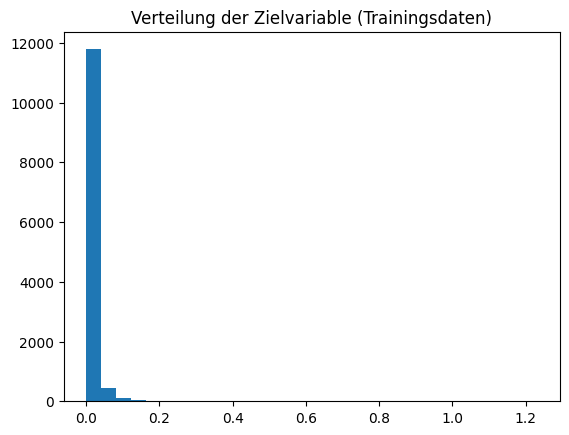

In [22]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=30)
plt.title("Verteilung der Zielvariable (Trainingsdaten)")
plt.show()


**-> extrem unausgewogene Zielverteilung!**  
Der Großteil der Zielvariablen (Scores) besteht aus Nullen , was es dem Modell schwer macht, die seltenen Fälle korrekt zu lernen.  

Herausforderungen bei extrem unausgewogenen Zielvariablen

- Modell-Bias zu den häufigsten Werten: Ein Machine-Learning-Modell wie ein Random Forest wird dazu neigen, die häufigste Klasse (in diesem Fall 0) vorherzusagen, da dies die einfachste Möglichkeit ist, den Fehler zu minimieren. Das Modell könnte also viele Nullen vorhersagen und dennoch eine niedrige Fehlerbewertung erhalten, weil die überwiegende Mehrheit der Zielvariablen Null ist.

- Schwierigkeit beim Lernen seltener Ereignisse: Da es nur wenige Datenpunkte gibt, die nicht Null sind, hat das Modell nicht genügend Beispiele, um die zugrunde liegenden Muster oder Beziehungen für diese Fälle zu lernen.

### mögliche Wege zur Verbesserung des Modells

#### **1. Andere Metriken verwenden**

Da MSE und R² in dieser Situation irreführend sein können, könnte es sinnvoll sein, alternative Metriken in Betracht zu ziehen, die besser geeignet sind, um unausgewogene Daten zu bewerten:

- Mean Absolute Error (MAE): Im Gegensatz zum MSE wird der MAE nicht durch Ausreißer oder stark ungleichgewichtige Daten verzerrt. Er könnte besser geeignet sein, um in dieser Situation zu verstehen, wie weit deine Vorhersagen im Durchschnitt von den tatsächlichen Werten entfernt sind.

- Precision, Recall und F1-Score für binäre Klassifizierung: Wenn die Vorhersage von Nicht-Null-Ereignissen wichtig ist, könntest du deine Regression in eine binäre Klassifizierung umwandeln (0 vs. Nicht-0) und diese Metriken verwenden, um die Leistung zu messen.



In [56]:
from sklearn.metrics import mean_absolute_error

# Vorhersagen für die Testdaten erstellen
y_test_pred = best_rf.predict(X_test)

# MAE berechnen
mae = mean_absolute_error(y_test, y_test_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")


Mean Absolute Error (MAE): 0.0157


Ein Mean Absolute Error (MAE) von 0.0157 bedeutet, dass die durchschnittliche absolute Abweichung der Vorhersagen von den tatsächlichen Werten etwa 0.0157 beträgt.  

Zielvariablen hauptsächlich Werte von 0  und alle unter 0.2 -> ist ein MAE von 0.0157 relativ klein. Dies deutet darauf hin, dass das Modell im Durchschnitt nicht stark von den tatsächlichen Werten abweicht. 

Zielvariable hat eine starke Tendenz zu 0, was bedeutet, dass die Fehler aufgrund der Verteilung der Daten klein erscheinen könnten. Ein MAE von 0.0157 in diesem Kontext könnte darauf hinweisen, dass dein Modell die häufig vorkommenden Werte (wie 0) gut vorhersagt.  

Ein MAE allein zeigt die mittlere Abweichung, sagt aber wenig über die gesamte Modellgüte aus.  
Da R² negativ ist oder die Werte nahe 0 sind, könnte das Modell dennoch insgesamt nicht gut performen, insbesondere wenn es sich schwer tut, die wenigen nicht-null Werte korrekt zu prognostizieren.

**Residuen:**  
Dies sind die Differenzen zwischen den tatsächlichen und den vorhergesagten Werten.

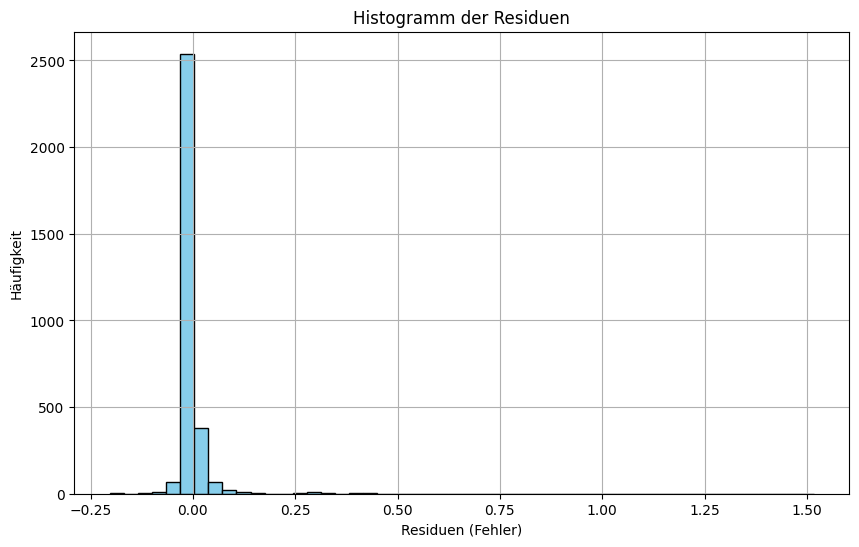

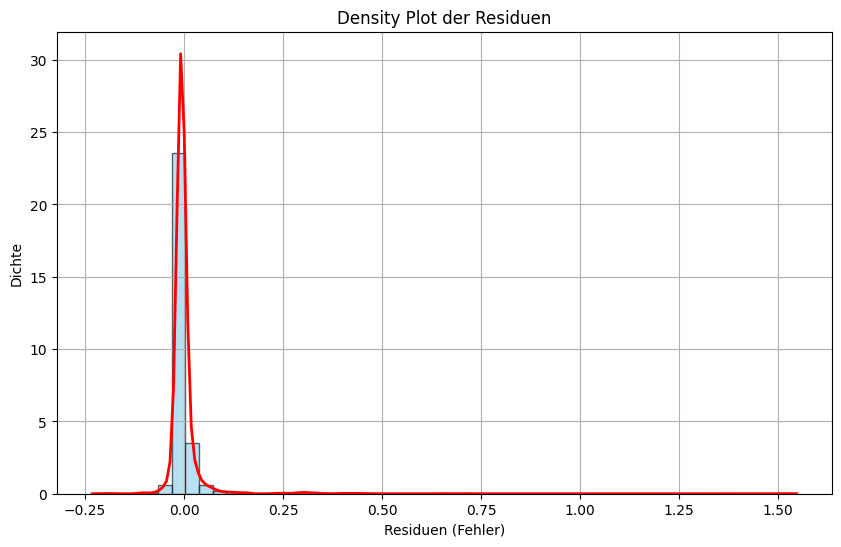

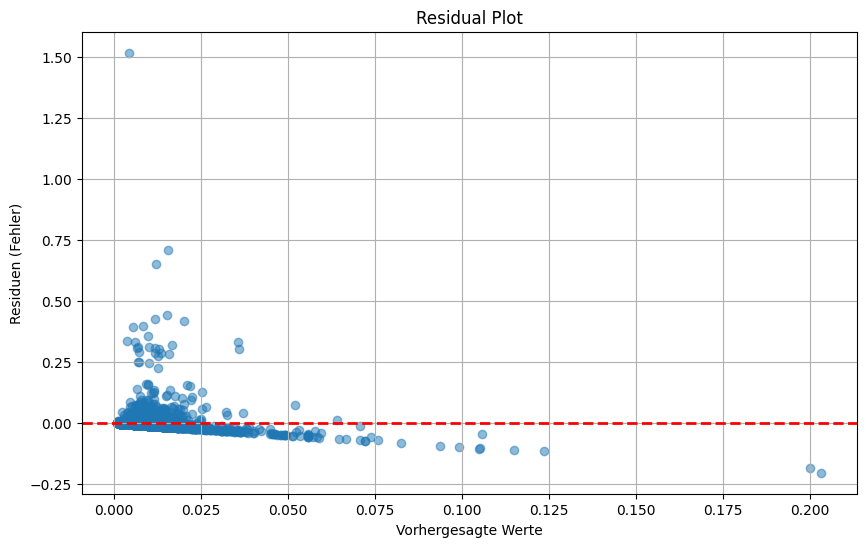

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

# Berechne die Residuen (Fehler)
residuals = y_test - y_test_pred

# 1. Histogramm der Residuen
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogramm der Residuen')
plt.xlabel('Residuen (Fehler)')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

# 2. Density Plot der Residuen
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.6)
sns.kdeplot(residuals, color='red', linewidth=2)
plt.title('Density Plot der Residuen')
plt.xlabel('Residuen (Fehler)')
plt.ylabel('Dichte')
plt.grid(True)
plt.show()

# 3. Residual Plot (Residuen vs. Vorhersagen)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Residuen (Fehler)')
plt.grid(True)
plt.show()


### 

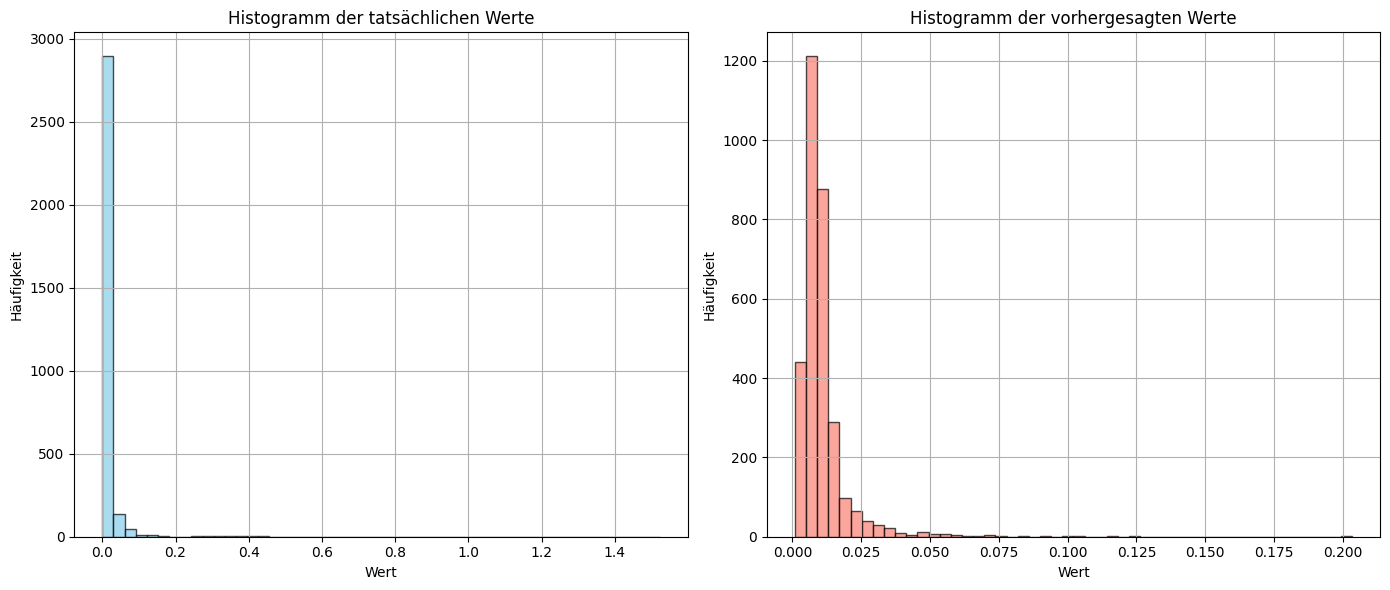

In [60]:
import matplotlib.pyplot as plt

# 1. Histogramm der tatsächlichen Werte
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogramm der tatsächlichen Werte')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.grid(True)

# 2. Histogramm der vorhergesagten Werte
plt.subplot(1, 2, 2)
plt.hist(y_test_pred, bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Histogramm der vorhergesagten Werte')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.grid(True)

plt.tight_layout()
plt.show()


### 

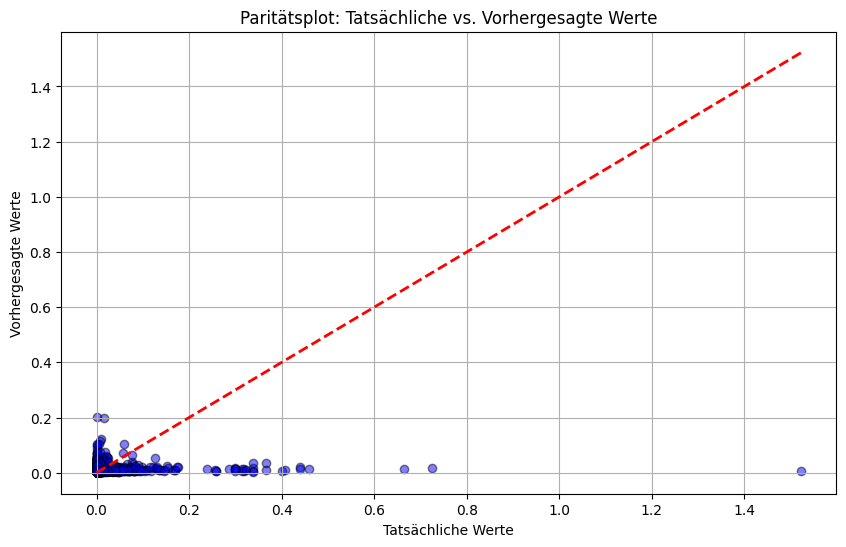

In [61]:
import matplotlib.pyplot as plt

# Erstelle den Paritätsplot
plt.figure(figsize=(10, 6))

# Scatter Plot der tatsächlichen vs. vorhergesagten Werte
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonale Linie
plt.title('Paritätsplot: Tatsächliche vs. Vorhergesagte Werte')
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.grid(True)
plt.show()


### 

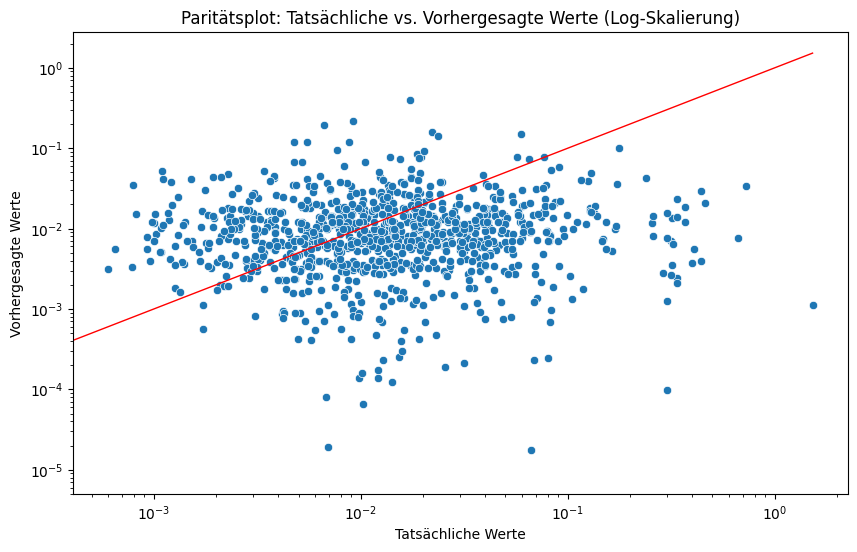

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=1)

# Logarithmische Skalierung der Achsen
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Paritätsplot: Tatsächliche vs. Vorhergesagte Werte (Log-Skalierung)')
plt.show()


#### **2. Umwandlung der Zielvariablen in eine binäre Klassifikation**

Problem in eine binäre Klassifikation umwandeln, bei der versucht wird vorherzusagen, ob der Wert der Zielvariablen Null oder Nicht-Null ist. Danach eine separate Vorhersage durchführen für den genauen Wert der Nicht-Null-Ziele. Dies könnte dem Modell helfen, die seltenen Nicht-Null-Ereignisse besser zu lernen.

**--> in diesem Notebook ausprobiert worden:** [Random Forest_3_klassifikation_regression](random_forest_3_klassifikation_regression.ipynb)

#### **3. Balancing der Zielvariable**

Da es ein extrem unausgewogenes Datenset ist, kann man versuchen, die Anzahl der Nullwerte zu reduzieren oder die Anzahl der Nicht-Null-Werte zu erhöhen, um ein ausgewogeneres Training zu erreichen:

- Oversampling der Nicht-Null-Werte: Erhöhen der Anzahl der Nicht-Null-Ereignisse durch Duplizieren oder Generieren von synthetischen Beispielen (z.B. mit SMOTE - Synthetic Minority Over-sampling Technique).

- Undersampling der Null-Werte: Reduzieren die Anzahl der Null-Ereignisse, um ein ausgeglicheneres Verhältnis zwischen Null und Nicht-Null zu erreichen.

**--> ist bei unserem Datensatz schwierig umzusetzen. Undersampling wegen eines ohnehin kleinen Datensatzes nicht sinnvoll. Genereiren synthetischer Daten ebenfalls schwierig - deshalb nicht angewendet**

#### **4. Feature Engineering**

- Nicht-lineare Transformationen der Zielvariable: Eine Transformation wie den Logarithmus oder die Quadratwurzel könnte dazu beitragen, die Verteilung zu stabilisieren und es dem Modell zu erleichtern, die nicht-Null-Ereignisse zu lernen, da es die Varianz erhöht.

- Zusätzliche Features: Versuche, neue Features zu generieren, die möglicherweise bessere Informationen über die seltenen Ereignisse liefern. Beispielsweise könntest du Interaktionsmerkmale, Polynomfunktionen oder Domain-spezifische Merkmale erstellen.



**Transformation mit Logarithmus**

In [26]:
import numpy as np
y_train_log = np.log1p(y_train)  # log1p für log(1 + y), um mit Nullwerten umzugehen
y_test_log = np.log1p(y_test)


**Vergleich ursprünglicher und transformierter Zielvariable:**

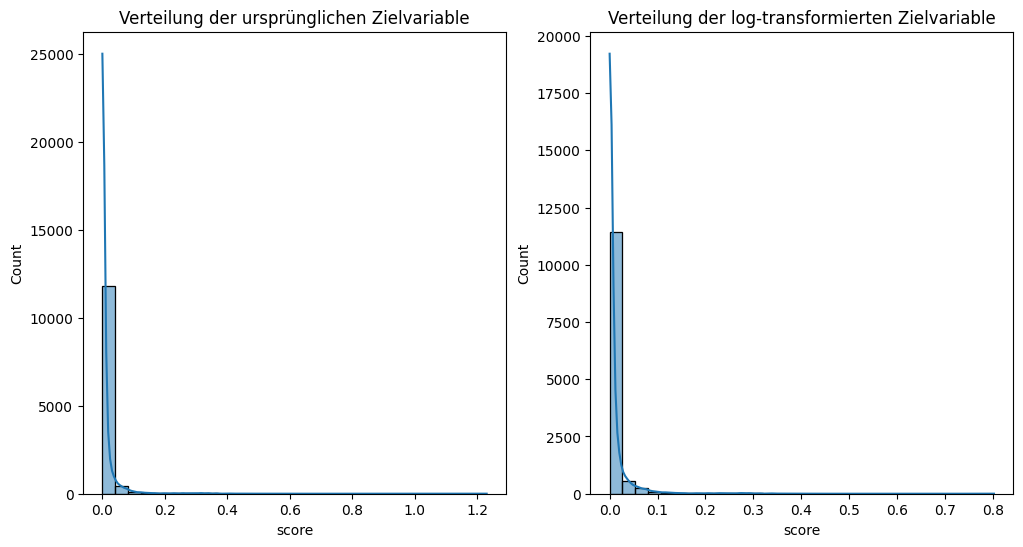

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Originale Zielvariable
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=30, kde=True)
plt.title('Verteilung der ursprünglichen Zielvariable')

# Transformierte Zielvariable
plt.subplot(1, 2, 2)
sns.histplot(y_train_log, bins=30, kde=True)
plt.title('Verteilung der log-transformierten Zielvariable')

plt.show()


In [24]:
print("Ursprüngliche Zielvariable:")
print(f"Mittelwert: {np.mean(y_train)}")
print(f"Median: {np.median(y_train)}")
print(f"Standardabweichung: {np.std(y_train)}")

print("\nTransformierte Zielvariable:")
print(f"Mittelwert: {np.mean(y_train_log)}")
print(f"Median: {np.median(y_train_log)}")
print(f"Standardabweichung: {np.std(y_train_log)}")


Ursprüngliche Zielvariable:
Mittelwert: 0.010466847652222295
Median: 0.0
Standardabweichung: 0.04203251934761113

Transformierte Zielvariable:
Mittelwert: 0.009731267901453658
Median: 0.0
Standardabweichung: 0.03493045439349697


**Mittelwert und Median:**

Der Mittelwert der transformierten Zielvariable ist etwas niedriger, während der Median gleich bleibt. Das deutet darauf hin, dass die Transformation möglicherweise die Extremwerte weniger beeinflusst hat.

**Standardabweichung:**

Die Standardabweichung der transformierten Zielvariable ist ebenfalls niedriger, was darauf hindeutet, dass die Werte um den Mittelwert herum etwas enger zusammenliegen. Dies kann helfen, die Stabilität des Modells zu verbessern, da es weniger anfällig für Ausreißer ist.

**Training Performance des Modells mit der transformierten Zielvariable überprüfen**

In [25]:
best_rf.fit(X_train, y_train_log)  # trainiere mit der transformierten Zielvariable
y_test_pred_log = best_rf.predict(X_test)

# Rücktransformation der Vorhersagen
y_test_pred = np.expm1(y_test_pred_log)  # expm1 für exp(y) - 1

# Berechne MSE und R²
mse_test_log = mean_squared_error(y_test, y_test_pred)
r2_test_log = r2_score(y_test, y_test_pred)

print(f"Test-MSE nach Transformation: {mse_test_log:.4f}")
print(f"Test-R^2 nach Transformation: {r2_test_log:.4f}")


Test-MSE nach Transformation: 0.0022
Test-R^2 nach Transformation: 0.0058


**Test-MSE: 0.0022**

Der MSE bleibt im Vergleich zu den vorherigen Ergebnissen gleich. Das bedeutet, dass die Transformation der Zielvariable in diesem Fall nicht zu einer Verbesserung der Fehlermaße geführt hat.

**Test-R²: 0.0058**

Der R²-Wert ist ebenfalls sehr niedrig, was darauf hindeutet, dass das Modell immer noch nicht in der Lage ist, die Varianz in den Daten gut zu erklären. Ein Wert nahe null bedeutet, dass das Modell kaum besser ist als der Mittelwert.

**Fazit: Keine Verbesserung** Die logarithmische Transformation hat in diesem Fall die Modellleistung nicht verbessert. 

**Transformation mit Quadratwurzel**

In [27]:
# Quadratwurzel-Transformation auf den ursprünglichen Zielvariablen
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)



Modelltraining: Training des Modell mit der transformierten Zielvariable:

In [28]:
best_rf.fit(X_train, y_train_sqrt)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=12, n_estimators=252, random_state=42)

Vorhersagen auf dem Testdatensatz:

In [30]:
y_test_pred_sqrt = best_rf.predict(X_test)


Rücktransformation der Vorhersagen:

In [31]:
y_test_pred = y_test_pred_sqrt ** 2


Bewertung des Modells: Berechnung MSE und R²:

In [32]:
mse_test_sqrt = mean_squared_error(y_test, y_test_pred)
r2_test_sqrt = r2_score(y_test, y_test_pred)

print(f"Test-MSE nach Quadratwurzel-Transformation: {mse_test_sqrt:.4f}")
print(f"Test-R^2 nach Quadratwurzel-Transformation: {r2_test_sqrt:.4f}")


Test-MSE nach Quadratwurzel-Transformation: 0.0023
Test-R^2 nach Quadratwurzel-Transformation: -0.0233


**Test-MSE: 0.0023**

Der MSE ist leicht gestiegen im Vergleich zu den vorherigen Ergebnissen (0.0022 nach der logarithmischen Transformation). Das deutet darauf hin, dass die Modellleistung möglicherweise nicht verbessert wurde.

**Test-R²: -0.0233**

Der R²-Wert ist weiterhin negativ, was bedeutet, dass das Modell immer noch nicht in der Lage ist, die Varianz in den Daten gut zu erklären. Ein negativer R²-Wert zeigt an, dass das Modell schlechter abschneidet als ein einfaches Modell, das einfach den Mittelwert vorhersagt.

**Fazit: Die Quadratwurzel-Transformation hat nicht zu einer Verbesserung der Modellleistung geführt.**

#### 5. Anwendung Custom Loss Function

**--> in diesem Notebook ausprobiert worden:** [Random Forest_4_custom_loss_function](random_forest_4_custom_loss_function.ipynb)

#### 6. Verwenden eines anderen Modells

Ein Random Forest ist möglicherweise nicht das beste Modell für diesen Fall. Andere Modelle wie Gradient Boosting Machines (GBM), XGBoost, CatBoost oder LightGBM sind manchmal besser für unausgewogene Datensätze geeignet, da sie flexibler und anpassungsfähiger auf die Gewichtung von Fehlern reagieren können.

##### FAZIT

Trotz zahlreicher Bemühungen das Modell zu verbessern, scheint Random Forest nicht geeignet zu sein, bzw. weist unser Datensatz sigfnikante Schwachstellen auf, um Vorhersagen machen zu könnn.  

Beste Werte

MSE: Der beste Test-MSE war 0.0022 nach der logarithmischen Transformation.     
R²: Der beste Test-R² war 0.0058, ebenfalls nach der logarithmischen Transformation.